### Звериный бутстреп

Скачайте из чата архив `animals.zip`, разархивируйте его и положите рядом с этим ноутбуком (иначе придется менять пути файлов). Если у вас не установлена библиотека `skimage` это можно сделать раскомменировав соответствующую команду следующей ячейки.

Готово! Теперь можно начинать работу над заданием.

In [1]:
import zipfile
with zipfile.ZipFile('animals.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [2]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from skimage.transform import resize

Имеются картинки пяти зверюшек, это наша выборка. Нужно оценить дисперсию среднего значения зверей. Для каждого пикселя картинки и для каждого цветового канала все операции проводим отдельно. 

Загружаем картинки зверюшек и приводим их к размеру 500 на 500. Каждая картинка представляется в виде трехмерной матрицы размера (500, 500, 3) чисел от 0 до 1. Первые две размерности отвечают за высоту и ширину картинки, третья за цветовые каналы --- красный, зеленый, синий.

По сути у нас есть выборка размера 5 из $(500\cdot500\cdot3)$-мерного пространства.

In [3]:
n = 5
images = [plt.imread('animals/animal_{}.jpg'.format(i+1)) for i in range (n)]
images = [resize(images[i], (500, 500, 3)) for i in range (n)]

Визуализируем все изображения при помощи функции `plt.imshow`. Вызов функций `plt.xticks([]), plt.yticks([])` убирает подписи к координатным осям, `plt.tight_layout`  обрезает пустые поля графиков, а `facecolor=(0,0,0,0)` делает фон графика прозрачным при сохранении (четыре числа -- красный, зеленый, синий, прозрачность).

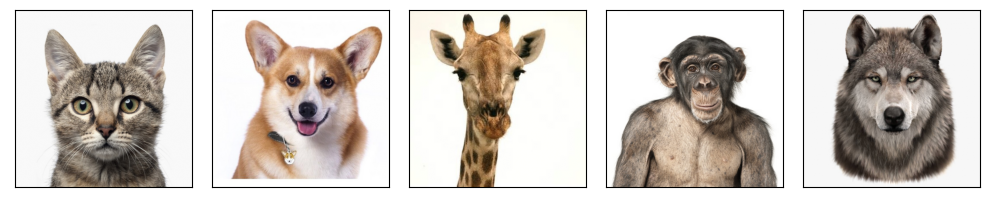

In [4]:
plt.figure(figsize=(10, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.savefig('zoo.png', facecolor=(0,0,0,0))
plt.show()

Для визуализации загрузим изображение стрелки

In [5]:
arrow = plt.imread('animals/arrow.png')

Функция, реализующая бутстреп

In [6]:
np.random.randint(5,size=1)

array([4])

In [7]:
def zoo_bootstrap(images, B=6, n_sample = 5, draw=False):
    '''
    Генерирует B бутстрепных выборок изображений 
    и возвращает среднее по каждой из них. 
    Если указан параметр draw, то рисует процесс на графике.
    '''
    import h5py
    # размер выборки
    n = len(images)
    # средние по бутстрепным выборкам
    bootstrap_means = []  
    
    if draw:
        plt.figure(figsize=(11.5, 9.5))

    with h5py.File('data.h5', 'w') as f: 
        dset =f.create_dataset(
            name='images',
            shape=(B,500, 500, 3),
            maxshape=(B,500, 500, 3),
            compression="gzip",
            compression_opts=9
        )    

        for b in range(B):
            # сумма элементов в бутстрепной выборке
            sum_bsample = 0

            for i in range(n_sample):
                # генерируем элемент бутстрепной выборки
                ind = np.random.randint(n,size=1,dtype=int)[0] # <сгенерируйте случайный индекс от 0 до n>
                # добавляем его к сумме по этой выборке
                sum_bsample += images[ind]

                # визуализация элемента бутстрепной выборки
                if draw:
                    plt.subplot(B, n+2, b*(n+2)+i+1)
                    plt.imshow(images[ind])
                    plt.xticks([]), plt.yticks([])
                    if i == 0:
                        plt.ylabel('$X^*_{}$:       '.format(b+1), 
                                rotation=0, fontsize=26)
            
            # добавляем среднее по бутстрепной выборке
            current_mean = sum_bsample / n_sample

            dset[b] = current_mean

            if draw:
                bootstrap_means.append(current_mean)
                # стрелка
                plt.subplot(B, n+2, b*(n+2)+i+2)
                plt.imshow(arrow)
                plt.axis('off'), plt.xticks([]), plt.yticks([])
                # среднее по бутстрепной выборке
                plt.subplot(B, n+2, b*(n+2)+i+3)
                plt.imshow(bootstrap_means[-1])
                plt.xticks([]), plt.yticks([])
                    
        if draw:
            plt.tight_layout()
            plt.savefig('animals/zoo_bootstrap.png', facecolor=(0,0,0,0))
            plt.show()
    
    return bootstrap_means if draw else None

Посмотрим, что получается на выборках размера 6. Ниже изображена схема бутстрепа. По строкам изображены бутстрепные выборки (разумеется, размера 5). В последнем столбце по каждой бутстрепной выборке посчитано среднее всех пикселей.

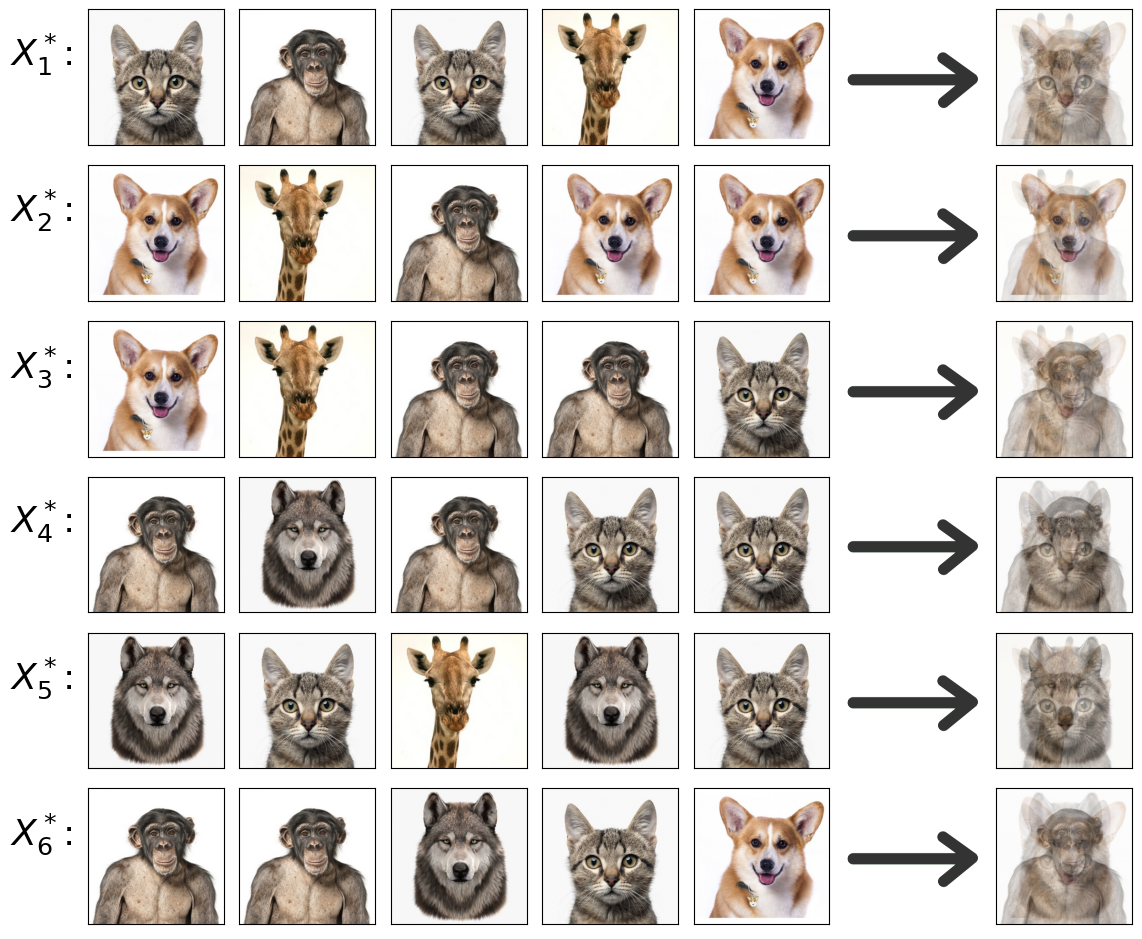

In [8]:
bootstrap_means = zoo_bootstrap(images, draw=True)

По бутстрепной выборке средних (правый столбец выше) можем посчитать выборочную дисперсию для каждого пикселя. Поскольку цвета изображения должны быть от 0 до 1, для визуализации нормируем все дисперсии на максимальное значение по всем пикселям и цветовым каналам. Очевидно, что минимальное значение дисперсий равно нулю --- в крайних пикселях всегда белый фон.

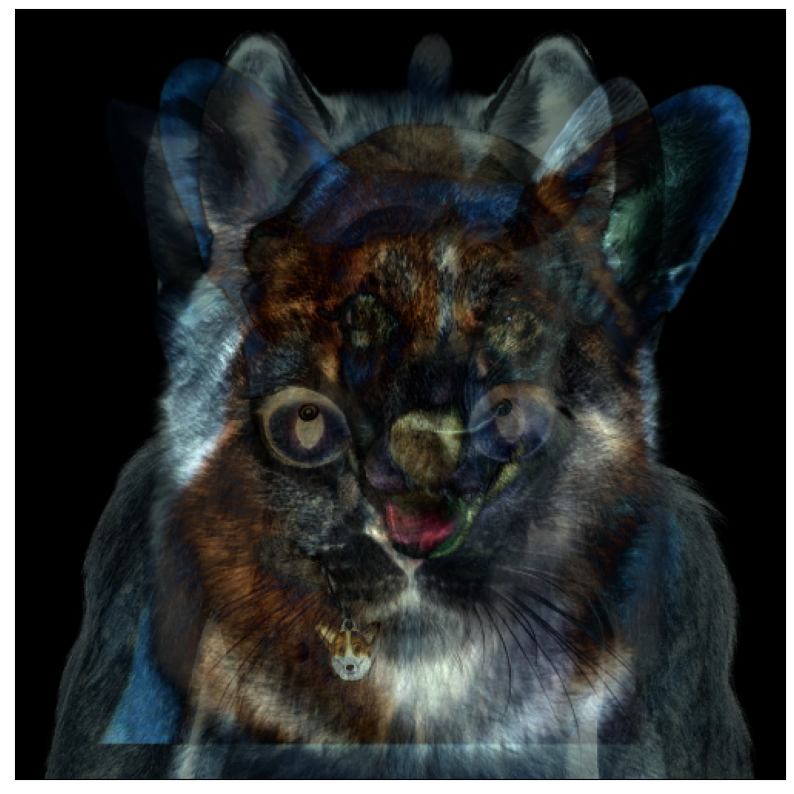

In [9]:
bootstrap_var =  np.var(bootstrap_means,axis=0)#<посчитайте дисперсию (не std) средних, полученных бутстрепом с учетом axis=0>
bvar_normed = bootstrap_var / bootstrap_var.max(axis=(0, 1)).reshape((1, 1, 3))

plt.figure(figsize=(10, 10))
plt.imshow(bvar_normed)
plt.xticks([]), plt.yticks([]);
plt.savefig('animals/zoo_bootstrap_var.png', facecolor=(0,0,0,0))
plt.show()

Посмотрим на результат при большем количестве бутстрепных выборок

In [10]:
import gc

gc.collect()

86032

Generated


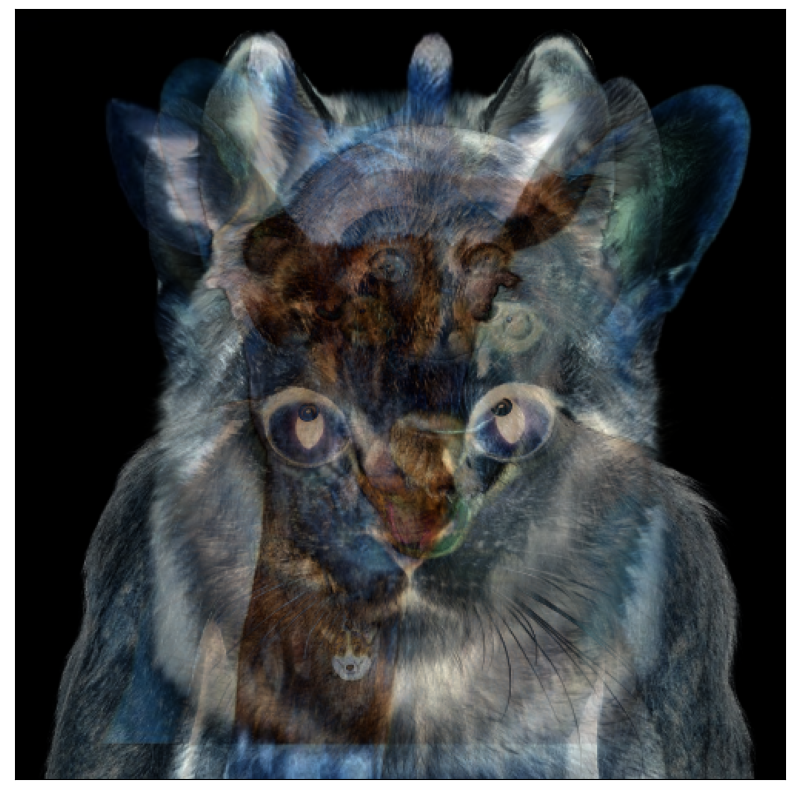

In [12]:
import dask.array as da
import h5py
zoo_bootstrap(images, B=300)
print('Generated')
with h5py.File('data.h5', 'r') as f:
    dset = f['images']
    x = da.from_array(dset, chunks=dset.chunks)
    y=x.var(axis=0)
    bootstrap_var = y.compute() #<посчитайте дисперсию (не std) средних, полученных бутстрепом с учетом axis=0>
    
bvar_normed = bootstrap_var / bootstrap_var.max(axis=(0, 1)).reshape((1, 1, 3))

plt.figure(figsize=(10, 10))
plt.imshow(bvar_normed)
plt.xticks([]), plt.yticks([]);
plt.savefig('animals/zoo_bootstrap_var.png', facecolor=(0,0,0,0))
plt.show()

------

Никита Волков

https://mipt-stats.gitlab.io/